In [235]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random.seed(6)
np.random.seed(6)


# Experiment 4 - MCQ One shot

In this experiment I want to check the how well the model reasons on the graph structure.

In the previous experiments a big setback was to effectively check the semantic correctness of the generate answer with the ground truth. For this experiment side step the problem of finding an adequate semantic similarity by asking the model to choose between some alternatives, therefore the model just needs to follow the template
and provide one of the valid alternatives.


**Parameters:**
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [236]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


In [237]:
gt_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7098 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   choices  7098 non-null   object
 1   num      7098 non-null   string
 2   text     7098 non-null   string
dtypes: object(1), string(2)
memory usage: 221.8+ KB


Loading the responses from the LLM

In [238]:
predictions = []
with open('../outputs/test.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,A: 2 The clothes
Interaction_T1_14,To determine which object was tidied up by the...
Interaction_T1_31,This space is reserved for your reasoning abou...
Interaction_T1_32,This space is reserved for your reasoning abou...
Interaction_T1_40,This space is reserved for your reasoning abou...
...,...
Feasibility_T6_1453,This space is reserved for your reasoning abou...
Feasibility_T6_1454,This space is reserved for your reasoning abou...
Feasibility_T6_1455,This space is reserved for your reasoning abou...


Let's first check a sound regex experssion to capture the answer template:

In [239]:
regex_pattern = r'^(?:\w+(?:\s|\/)?){,10}\.$'
mask = gt_df['text'].str.contains(regex_pattern, case=False, regex=True)
mask.value_counts()


True    7098
Name: text, dtype: Int64

Let's start by viewing how many answers follow the template:

In [240]:
# ?: in the regex defines a non capturing group
#
# Compared to the cell above we need to add the \d\.s to account for the
# digit when choosing an alternative between the proposed one in the prompt

ans_regex_pattern = r'A:\s*(?:\d\.?)?\s*((?:\w+(?:\s+|\/)?){,10})'
template_answer_mask = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True)

template_answ_count = template_answer_mask.value_counts()[True]

print(f"Answer following the template: {template_answer_mask.value_counts()[True]}\n"
      f"{template_answer_mask.value_counts()[True]/predictions_df.size:.2%} of the total")


Answer following the template: 6396
90.11% of the total


/tmp/ipykernel_897004/2289927494.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  template_answer_mask = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True)


Some responses do not follow the expected template format of "N. Answer text". Let's analyze these non-conforming responses in the following cells to understand their patterns and how to handle them.


In [241]:
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True)


print(f"Answer fotype(gt_df.iloc[0]['choices'])llowing the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer fotype(gt_df.iloc[0]['choices'])llowing the template: 6396
90.11% of the total

Only 702 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_897004/4219478900.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True)


Let's inspect what this responses looks like

In [242]:
to_inspect_df = predictions_df[~contains_answer]
to_inspect_df['answer']


id
Interaction_T1_14      To determine which object was tidied up by the...
Interaction_T1_100     This space is reserved for your reasoning abou...
Interaction_T1_111     This space is reserved for your reasoning abou...
Interaction_T1_288     This space is reserved for your reasoning abou...
Interaction_T1_294     This space is reserved for your reasoning abou...
                                             ...                        
Feasibility_T6_1364    This space is reserved for your reasoning abou...
Feasibility_T6_1392    This space is reserved for your reasoning abou...
Feasibility_T6_1405    This space is reserved for your reasoning abou...
Feasibility_T6_1412    This space is reserved for your reasoning abou...
Feasibility_T6_1448    This Spatio-Temporal Scene-Graph shows the per...
Name: answer, Length: 702, dtype: string

## Extracting the answers

In [243]:
predictions_df.loc[contains_answer].iloc[:2]['answer']

id
Interaction_T1_13                                     A: 2 The clothes
Interaction_T1_31    This space is reserved for your reasoning abou...
Name: answer, dtype: string

In [244]:
predictions_df.loc[contains_answer].iloc[:5]['answer'].str.extract(ans_regex_pattern)

,0
id,
Interaction_T1_13,The clothes
Interaction_T1_31,The bag
Interaction_T1_32,The clothes
Interaction_T1_40,The clothes
Interaction_T1_43,The clothes


Let's extract the the answers from the generated texts which do contain an answer:

In [245]:
ans_df = predictions_df.loc[contains_answer]['answer'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The clothes
Interaction_T1_31,The bag
Interaction_T1_32,The clothes
Interaction_T1_40,The clothes
Interaction_T1_43,The clothes
...,...
Feasibility_T6_1453,Wash the table
Feasibility_T6_1454,Throw the bag
Feasibility_T6_1455,Wash the table


In [246]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6396 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6392 non-null   string
dtypes: string(1)
memory usage: 99.9 KB


In [247]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 568 unique answers


Let's do some visualization also for the ground truth data

In [248]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


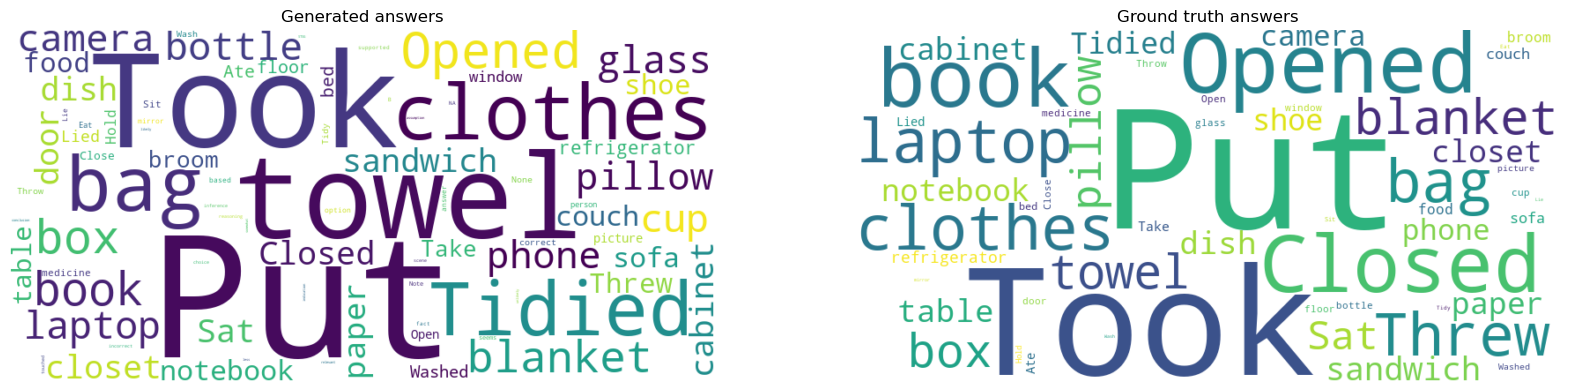

In [249]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


In [250]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'num': 'pred_num', 'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we don't also for samples without answers
)

eval_df.shape


(6396, 4)

In [251]:
# Removing the dot from gt answers
eval_df['text'] = eval_df['text'].apply(lambda x: x[:-1])


In [252]:
eval_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6396 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   choices    6396 non-null   object
 1   num        6396 non-null   string
 2   text       6396 non-null   object
 3   pred_text  6392 non-null   string
dtypes: object(2), string(2)
memory usage: 249.8+ KB


In [253]:
# how the 'pred_text' looks for samples without answers
eval_df[~contains_answer]['pred_text']#num_acc = accuracy(eval_df, on_what='num')

#print(f"Numeric Accuracy: {num_acc:.2%}")


/tmp/ipykernel_897004/1410892783.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eval_df[~contains_answer]['pred_text']#num_acc = accuracy(eval_df, on_what='num')


Series([], Name: pred_text, dtype: string)

In [254]:
def accuracy(eval_df, on_what='text'):
    # hits_num = (eval_df['pred_num'] == eval_df['num']).sum()
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [255]:
eval_df[eval_df['text'] == eval_df['pred_text']]

,choices,num,text,pred_text
id,,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes,The clothes
Interaction_T1_43,"{'0': 'The box.', '1': 'The pillow.', '2': 'Th...",3,The clothes,The clothes
Interaction_T1_70,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe,The shoe
Interaction_T1_71,"{'0': 'The paper/notebook.', '1': 'The clothes...",0,The paper/notebook,The paper/notebook
Interaction_T1_78,"{'0': 'The laptop.', '1': 'The refrigerator.',...",0,The laptop,The laptop
...,...,...,...,...
Feasibility_T6_1428,"{'0': 'Close the refrigerator.', '1': 'Throw t...",3,Take the cup/glass/bottle,Take the cup/glass/bottle
Feasibility_T6_1449,"{'0': 'Throw the towel.', '1': 'Close the refr...",2,Put down the laptop,Put down the laptop
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table,Wash the table


In [256]:
text_acc = accuracy(eval_df)

print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 46.84%


check if the equality with NA result in a false or is skipped

In [257]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 42.21%


In [258]:

def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [259]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2150        46.47%  
Sequence            3227        47.32%  
Prediction           581        45.78%  
Feasibility          438        46.58%  


## Inspecting the mismatch

The discrepancy in accuracy values between evaluations conducted on the text portion of the answer and those performed on the numeric prefix suggests that the model struggles to exactly reproduce one of the proposed alternatives.  

Let's check with the prompt for this mismatch

### Verify that GT and prompts have the same alternatives

It should be so base on how they are created but a furhter check wont' hurt.
If so then we can use the `choices` column in gt_df

In [260]:
p_choices = prompts_df['prompt'].str.split('\n', expand=True)
p_choices


NameError: name 'prompts_df' is not defined

In [ ]:
p_choices.drop(columns=[0,5,6], inplace=True)


In [ ]:
gt_choices = pd.DataFrame(index=gt_df.index)
gt_choices[[1,2,3,4]] = gt_df['choices'].apply(lambda x: [f'{k}. {v}' for k,v in x.items()]).tolist()

gt_choices


,1,2,3,4
id,,,,
Interaction_T1_13,0. The closet/cabinet.,1. The blanket.,2. The clothes.,3. The table.
Interaction_T1_14,0. The blanket.,1. The table.,2. The clothes.,3. The closet/cabinet.
Interaction_T1_31,0. The pillow.,1. The bag.,2. The clothes.,3. The box.
Interaction_T1_32,0. The food.,1. The shoe.,2. The blanket.,3. The sandwich.
Interaction_T1_40,0. The broom.,1. The closet/cabinet.,2. The blanket.,3. The table.
...,...,...,...,...
Feasibility_T6_1453,0. Wash the table.,1. Take the box.,2. Put down the phone/camera.,3. Open the bag.
Feasibility_T6_1454,0. Take the towel.,1. Throw the bag.,2. Hold the clothes.,3. Hold the box.
Feasibility_T6_1455,0. Throw the bag.,1. Wash the table.,2. Close the box.,3. Take the shoe.


In [ ]:

gt_choices == p_choices


,1,2,3,4
id,,,,
Interaction_T1_13,True,True,True,True
Interaction_T1_14,True,True,True,True
Interaction_T1_31,True,True,True,True
Interaction_T1_32,True,True,True,True
Interaction_T1_40,True,True,True,True
...,...,...,...,...
Feasibility_T6_1453,True,True,True,True
Feasibility_T6_1454,True,True,True,True
Feasibility_T6_1455,True,True,True,True


In [ ]:
# applying the logical and first by row and then by columns
# we check that we have a correct for each alternative and for
# in each QA


(gt_choices == p_choices).all(axis=1).all()


True

### Each given answer is in the set of proposed alternatives?

Check that the given **textual answer** is among the choices.

In [ ]:
mask = eval_df[contains_answer].apply(lambda x: x['pred_text'] in list(x['choices'].values()), axis=1)
mask.value_counts()


True     7046
False      36
dtype: int64

Check that the index of the given answer correspond to the index of the choices as preseted by the prompt

In [ ]:
eval_df.loc[contains_answer].loc[mask].apply(lambda x: x['choices'][x['pred_num']] == x['pred_text'], axis=1).value_counts()


True     5298
False    1748
dtype: int64

The results show that in approximately 30% of cases, the model fails to correctly match the index of the alternative with the corresponding text.

On the other hand, it successfully repeats the text from one of the choices in the majority of samples, demonstrating a strong gorunding on the proposed text.